In [1]:
import numpy as np 
import pandas as pd 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
!pip install scikit-learn==1.4.2 imbalanced-learn==0.12.2

/kaggle/input/Indian Liver Patient Dataset (ILPD).csv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.


### **Project Overview**

This notebook is an extension of Replication of Liver Disease Classification - KNN, where I replicated key parts of the paper - “Tabular Data Generation to Improve Classification of Liver Disease Diagnosis” by _Mohammad Alauthman et al._ - but used just KNN. 

Here I would be doing carrrying out the previous objectves while using KNN Classification

### **Objective**

In this notebook, I will:

1.	Perform a train–validation split, and apply SMOTE only to the training data.
2.  Train an KNN classifier with cross-validation on the training set.
3.  Evaluate the model’s performance before and after applying SMOTE to understand the impact of oversampling on classification quality.
4.  Fine-tune the KNN hyperparameters.
5.  Retrain the model using the optimized parameters and evaluate it on the validation dataset.
6.  Use SHAP values to explain the model’s predictions and identify key contributing features.

In [2]:
path = "/kaggle/input/Indian Liver Patient Dataset (ILPD).csv"
data=pd.read_csv(path)

cols = ['Age','Gender','TB_total_bilirubin', 'DB_Direct_Bilirubin',
       'Alkphos_Alkaline_Phosphotase', 'Sgpt_Alamine_Aminotransferase',
       'Sgot_Aspartate_Aminotransferase', 'TP_Total_Protiens', 'ALB_Albumin',
       'A/G_Ratio','Selector']
data.columns = cols
data.head()

,Age,Gender,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Selector
0,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1


In [3]:
# one hot encode categorical data
data = pd.get_dummies(data)
data.head()

,Age,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Selector,Gender_Female,Gender_Male
0,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,False,True
1,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,False,True
2,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,False,True
3,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,False,True
4,46,1.8,0.7,208,19,14,7.6,4.4,1.30,1,False,True


In [4]:
# replace NaN values with mean
data['A/G_Ratio'] = data['A/G_Ratio'].fillna(data['A/G_Ratio'].mean())
data['A/G_Ratio'].isna().sum()

# Normalize class labels to 0 and 1
data['Selector']= data['Selector'].replace({1: 0, 2: 1})

data["Gender_Female"] = data["Gender_Female"].astype(int)
data["Gender_Male"] = data["Gender_Male"].astype(int)


In [5]:
data.head()

,Age,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Selector,Gender_Female,Gender_Male
0,62,10.9,5.5,699,64,100,7.5,3.2,0.74,0,0,1
1,62,7.3,4.1,490,60,68,7.0,3.3,0.89,0,0,1
2,58,1.0,0.4,182,14,20,6.8,3.4,1.00,0,0,1
3,72,3.9,2.0,195,27,59,7.3,2.4,0.40,0,0,1
4,46,1.8,0.7,208,19,14,7.6,4.4,1.30,0,0,1


In [6]:
# set y
y = data.Selector

# Update the columns list post one hot encoding 
cols = data.columns.tolist()
cols.remove("Selector")

# set X
features = cols
X = data[features]

In [7]:
# Train test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57, stratify=y)

In [8]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier


mcc_scorer = make_scorer(matthews_corrcoef)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'mcc': make_scorer(matthews_corrcoef)
}


# Create and train the MLP Classifier
ilp_model = KNeighborsClassifier()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)  # fit + transform
X_test_scaled = scaler.transform(X_test)

skf = StratifiedKFold(n_splits=10)
cv_results = cross_validate(ilp_model, X_scaled, y_train, cv=skf, scoring=scoring)

# Average scores
for metric in scoring:
    print(f"Average {metric}: {cv_results['test_' + metric].mean():.3f}")


Average accuracy: 0.663
Average recall: 0.369
Average precision: 0.400
Average f1: 0.381
Average mcc: 0.152


In [9]:
# Create a dataframe with appropriate column names to report the traning metrics 
training_results = pd.DataFrame(columns=["case", "accuracy", "recall", "precision", "f1", "mcc"])

In [10]:
# retrieve the for the initial dataset metrics and add them to the df
metric_list = ["UNBALANCED"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

training_results.loc[len(training_results)] = metric_list
training_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6625,0.3687,0.3998,0.3808,0.1518


### Augmentation with SMOTE (Synthetic Minority Oversampling Technique - SMOTE)

In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y_train)

print("After SMOTE:", Counter(y_smote))

Before SMOTE: Counter({0: 332, 1: 133})
After SMOTE: Counter({0: 332, 1: 332})


In [12]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_smote, y_smote, cv=skf, scoring=scoring)

# retrieve the for the initial dataset metrics and add them to the df
metric_list = ["BAL-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

training_results.loc[len(training_results)] = metric_list
training_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6625,0.3687,0.3998,0.3808,0.1518
1,BAL-AUG,0.7502,0.9100,0.6899,0.7841,0.5302


In [13]:
# get current number of rows
current_count = Counter(y_smote)[1]
double = current_count * 2
triple = current_count * 3
quadrupule = current_count * 4

In [14]:
# DOUBLE THE DATA WITH SMOTE
# double y with index 1
smote_double = SMOTE(sampling_strategy={1: double}, random_state=42)  
X_double, y_double = smote_double.fit_resample(X_smote, y_smote)
print("Double SMOTE:", Counter(y_double))

# normalize index 1 and 2, effectively doubling the data
smote_double = SMOTE(random_state=42)
X_double, y_double = smote_double.fit_resample(X_double, y_double)
print("Double SMOTE:", Counter(y_double))

Double SMOTE: Counter({1: 664, 0: 332})
Double SMOTE: Counter({0: 664, 1: 664})


In [15]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_double, y_double, cv=skf, scoring=scoring)

# retrieve the metrics for the dataset augmented 2 fold and add them to the df
metric_list = ["DD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

training_results.loc[len(training_results)] = metric_list
training_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6625,0.3687,0.3998,0.3808,0.1518
1,BAL-AUG,0.7502,0.9100,0.6899,0.7841,0.5302
2,DD-AUG,0.8773,0.9365,0.8376,0.8835,0.7618


In [16]:
# TRIPLE THE DATA WITH SMOTE

# Triple the data 
smote_triple = SMOTE(sampling_strategy={1: triple}, random_state=42)  
X_triple, y_triple = smote_triple.fit_resample(X_smote, y_smote)

# normalize index 1 and 2, effectively doubling the data
smote_triple = SMOTE(random_state=42)
X_triple, y_triple = smote_double.fit_resample(X_triple, y_triple)
print("Double SMOTE:", Counter(y_triple))

Double SMOTE: Counter({0: 996, 1: 996})


In [17]:
# calculate with augmented data
cv_results = cross_validate(ilp_model, X_triple, y_triple, cv=skf, scoring=scoring, return_train_score=True)
print("Training mcc:", cv_results['train_mcc'].mean())
print("Validation mcc:", cv_results['test_mcc'].mean())

# retrieve the metrics for the dataset augmented 3 fold and add them to the df
metric_list = ["TD-AUG"]
for metric in scoring:
    metric_list.append(round(cv_results['test_' + metric].mean(), 4))

training_results.loc[len(training_results)] = metric_list

Training mcc: 0.9213644748240609
Validation mcc: 0.8539810650410175


In [18]:
training_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6625,0.3687,0.3998,0.3808,0.1518
1,BAL-AUG,0.7502,0.9100,0.6899,0.7841,0.5302
2,DD-AUG,0.8773,0.9365,0.8376,0.8835,0.7618
3,TD-AUG,0.9252,0.9679,0.8923,0.9284,0.8540


### Validate

In [19]:
# Create a dataframe with appropriate column names to report the test metrics 
validation_results = pd.DataFrame(columns=["case", "accuracy", "recall", "precision", "f1", "mcc"])

In [20]:
X_train.head()

,Age,TB_total_bilirubin,DB_Direct_Bilirubin,Alkphos_Alkaline_Phosphotase,Sgpt_Alamine_Aminotransferase,Sgot_Aspartate_Aminotransferase,TP_Total_Protiens,ALB_Albumin,A/G_Ratio,Gender_Female,Gender_Male
259,42,16.4,8.9,245,56,87,5.4,2.0,0.50,0,1
149,56,1.1,0.5,180,30,42,6.9,3.8,1.20,0,1
1,62,7.3,4.1,490,60,68,7.0,3.3,0.89,0,1
177,75,10.6,5.0,562,37,29,5.1,1.8,0.50,0,1
444,17,0.9,0.2,279,40,46,7.3,4.0,1.20,0,1


In [21]:
X_smote = pd.DataFrame(X_smote, columns=X_train.columns)
X_double = pd.DataFrame(X_double, columns=X_train.columns)
X_triple = pd.DataFrame(X_triple, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [22]:
# Fit the model with the initially unbalanced dataset and record results 
ilp_model.fit(X_train, y_train)
y_pred = ilp_model.predict(X_test_scaled)


validation_results.loc[len(validation_results)] = {
    "case": "NO-AUG",
    "accuracy": accuracy_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "mcc": matthews_corrcoef(y_test, y_pred)
}

# Fit the model with the dataset_balaced with smote and record results 
ilp_model.fit(X_smote, y_smote)
y_pred = ilp_model.predict(X_test_scaled)


validation_results.loc[len(validation_results)] = {
    "case": "AUG",
    "accuracy": accuracy_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "mcc": matthews_corrcoef(y_test, y_pred)
}

# Fit the model with the 2x the data and record results 
ilp_model.fit(X_double, y_double)
y_pred = ilp_model.predict(X_test_scaled)


validation_results.loc[len(validation_results)] = {
    "case": "DD-AUG",
    "accuracy": accuracy_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "mcc": matthews_corrcoef(y_test, y_pred)
}


# Fit the model with the 3x the data and record results 
ilp_model.fit(X_triple, y_triple)
y_pred = ilp_model.predict(X_test_scaled)


validation_results.loc[len(validation_results)] = {
    "case": "TD-AUG",
    "accuracy": accuracy_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "mcc": matthews_corrcoef(y_test, y_pred)
}

validation_results.head()

,case,accuracy,recall,precision,f1,mcc
0,NO-AUG,0.709402,0.000000,0.000000,0.000000,0.000000
1,AUG,0.572650,0.705882,0.375000,0.489796,0.204273
2,DD-AUG,0.623932,0.705882,0.413793,0.521739,0.269022
3,TD-AUG,0.649573,0.735294,0.438596,0.549451,0.317706


### Results

In [23]:
training_results.head()

,case,accuracy,recall,precision,f1,mcc
0,UNBALANCED,0.6625,0.3687,0.3998,0.3808,0.1518
1,BAL-AUG,0.7502,0.9100,0.6899,0.7841,0.5302
2,DD-AUG,0.8773,0.9365,0.8376,0.8835,0.7618
3,TD-AUG,0.9252,0.9679,0.8923,0.9284,0.8540


In [24]:
validation_results.head()

,case,accuracy,recall,precision,f1,mcc
0,NO-AUG,0.709402,0.000000,0.000000,0.000000,0.000000
1,AUG,0.572650,0.705882,0.375000,0.489796,0.204273
2,DD-AUG,0.623932,0.705882,0.413793,0.521739,0.269022
3,TD-AUG,0.649573,0.735294,0.438596,0.549451,0.317706


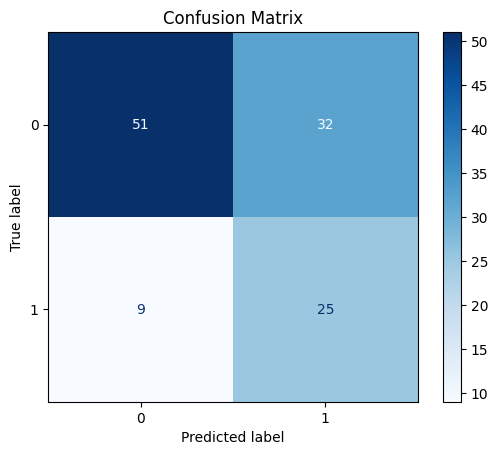


Confusion Matrix Details:
True Negatives: 51
False Positives: 32
False Negatives: 9
True Positives: 25
Accuracy: 0.6496
Precision: 0.4386
Recall: 0.7353


In [25]:
# PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Additional metrics from confusion matrix
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix Details:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
    print(f"Precision: {tp / (tp + fp):.4f}" if (tp + fp) > 0 else "Precision: undefined")
    print(f"Recall: {tp / (tp + fn):.4f}" if (tp + fn) > 0 else "Recall: undefined")


  0%|          | 0/117 [00:00<?, ?it/s]

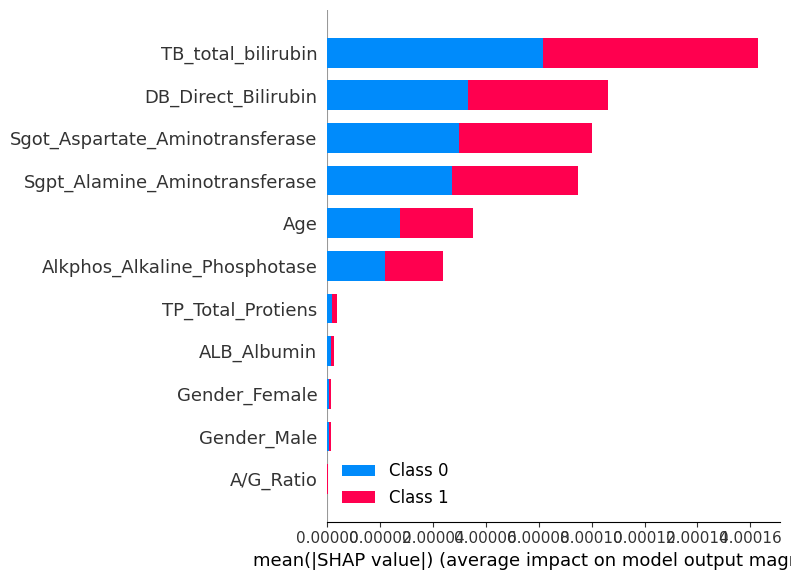

In [26]:
import shap

# Use a small subset for background data (helps speed)
background = X_train.sample(100, random_state=42)

explainer = shap.KernelExplainer(ilp_model.predict_proba, background)
shap_values = explainer.shap_values(X_test)

# summary plot
shap.summary_plot(shap_values, X_test)

  0%|          | 0/50 [00:00<?, ?it/s]

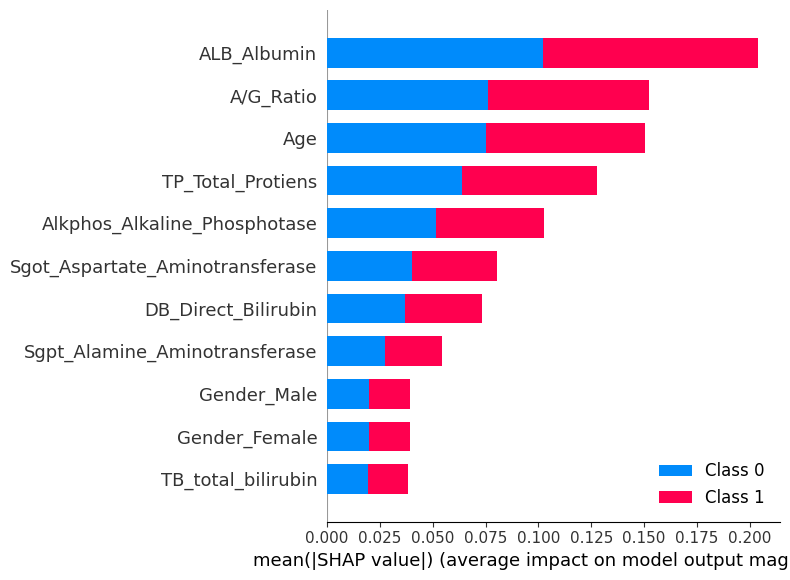

SHAP analysis completed.


In [27]:
import shap

# Using a small background sample (first 50 rows) for efficiency 
explainer = shap.KernelExplainer(ilp_model.predict_proba, X_smote[:50])

# Compute SHAP values for the same small subset
shap_values = explainer.shap_values(X_smote[:50])

# Display a global summary plot of feature importance and impact
shap.summary_plot(shap_values, X_smote[:50])

print("SHAP analysis completed.")

## Notes
### 22-11-25, 08:37

### FINAL RESULTS:

**KNN + SOMTE TRAINING RESULTS** 

| case       | accuracy | recall | precision | f1     | mcc    |
| ---------- | -------- | ------ | --------- | ------ | ------ |
| UNBALANCED | 0.8075   | 0.1140 | 0.2407    | 0.1138 | 0.0674 |
| BAL-AUG    | 0.8422   | 0.8872 | 0.8180    | 0.8496 | 0.6893 |
| DD-AUG     | 0.9224   | 0.9434 | 0.9062    | 0.9241 | 0.8462 |
| TD-AUG     | 0.9461   | 0.9624 | 0.9321    | 0.9469 | 0.8928 |


**KNN + SOMTE VALIDATION RESULTS** 

| case   | accuracy | recall   | precision | f1       | mcc      |
| ------ | -------- | -------- | --------- | -------- | -------- |
| NO-AUG | 0.393162 | 0.764706 | 0.292135  | 0.422764 | 0.006033 |
| AUG    | 0.692308 | 0.500000 | 0.472222  | 0.485714 | 0.266679 |
| DD-AUG | 0.692308 | 0.470588 | 0.470588  | 0.470588 | 0.253721 |
| TD-AUG | 0.752137 | 0.529412 | 0.580645  | 0.553846 | 0.383537 |

### SUMMARY:

